# <center> Difference In Differences

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
df = pd.read_csv(r'daily_data.csv')
df.head()

,date,n_trialers,cvr
0,2021-01-01,44,0.454545
1,2021-01-02,51,0.392157
2,2021-01-03,56,0.500000
3,2021-01-04,71,0.450704
4,2021-01-05,56,0.428571


### Create synthetic test set

In [3]:
# Create test set from control with some level of noise
df['cvr_synthetic'] = df['cvr'] + np.random.normal(0,0.04, len(df))

# Label the last 30 days test data
test_start_date = '2022-06-01'
df['is_test'] = 0
df.loc[df['date'] >= test_start_date, 'is_test'] = 1

In [4]:
# View DataFrame
df.head()

,date,n_trialers,cvr,cvr_synthetic,is_test
0,2021-01-01,44,0.454545,0.423053,0
1,2021-01-02,51,0.392157,0.367575,0
2,2021-01-03,56,0.500000,0.465146,0
3,2021-01-04,71,0.450704,0.513398,0
4,2021-01-05,56,0.428571,0.414102,0


In [5]:
# View how many days the test has been running
df['is_test'].value_counts()

0    516
1     30
Name: is_test, dtype: int64

In [6]:
# Check correlation of test and control cvr
round(df[['cvr','cvr_synthetic']].corr(),2)

,cvr,cvr_synthetic
cvr,1.00,0.82
cvr_synthetic,0.82,1.00


In [7]:
# Create uplift in test dataset
uplift = 0.02
df.loc[df['is_test'] == 1, 'cvr_synthetic'] = df.loc[df['is_test'] == 1, 'cvr_synthetic'] + uplift

### Calculate Rolling Average (for plotting)

In [8]:
df['cvr_r7'] = df.groupby(['is_test'])['cvr'].rolling(7).mean().reset_index(level=0, drop=True)
df['cvr_synthetic_r7'] = df.groupby(['is_test'])['cvr_synthetic'].rolling(7).mean().reset_index(level=0, drop=True)

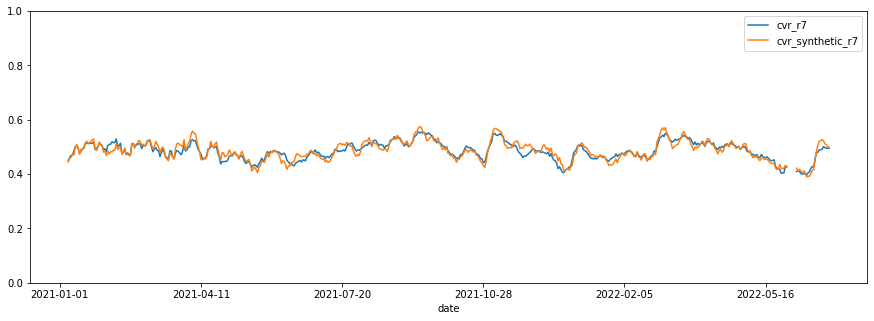

In [9]:
df.plot(x="date", y=["cvr_r7", "cvr_synthetic_r7"], figsize=(15,5), ylim=(0,1));

In [10]:
df['delta'] = df['cvr_synthetic'] - df['cvr']

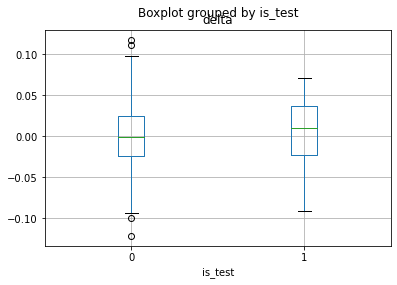

In [11]:
df.boxplot('delta',by='is_test');

In [12]:
a = df.loc[df['is_test'] == 0, 'delta']
b = df.loc[df['is_test'] == 1, 'delta']

In [13]:
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-0.9984742452790422, pvalue=0.318493363104388)

# <center> Iterate and Test

In [14]:
iterations = 100
noises = np.arange(0,0.11,0.01)
effect_sizes = np.arange(0,0.11,0.01)
r2_list = []

In [15]:
df_results = pd.DataFrame(index=effect_sizes, columns=noises)
df_results.index.name = 'effect_size'
df_results.columns.name = 'r2'

In [16]:
for n in noises:
    
    for e in effect_sizes:
        
        rejections = []
        r2s = []
        
        for i in range(iterations):
            
            df_temp = pd.read_csv(r'daily_data.csv')

            df_temp['cvr_synthetic'] = df_temp['cvr'] + np.random.normal(0,n, len(df_temp))
            test_start_date = '2022-06-01'
            df_temp['is_test'] = 0
            df_temp.loc[df_temp['date'] >= test_start_date, 'is_test'] = 1

            r2 = round(df_temp[['cvr','cvr_synthetic']].corr(),2)['cvr'][1]
            r2s.append(r2)
            df_temp.loc[df_temp['is_test'] == 1, 'cvr_synthetic'] = df_temp.loc[df_temp['is_test'] == 1, 'cvr_synthetic'] + e

            df_temp['delta'] = df_temp['cvr_synthetic'] - df_temp['cvr']

            a = df_temp.loc[df_temp['is_test'] == 0, 'delta']
            b = df_temp.loc[df_temp['is_test'] == 1, 'delta']

            p_val = round(stats.ttest_ind(a, b)[1],2)

            reject_null = 1 if p_val <= 0.05 else 0
            rejections.append(reject_null)

        df_results.loc[e,n] = np.mean(rejections)
        
    r2_list.append(np.mean(r2s))

In [17]:
r2_list = [round(i,3) for i in r2_list]
df_results.columns = r2_list

In [18]:
df_results

,1.000,0.980,0.936,0.870,0.798,0.724,0.659,0.601,0.548,0.501,0.465
effect_size,,,,,,,,,,,
0.00,0.0,0.05,0.05,0.05,0.08,0.06,0.07,0.04,0.02,0.04,0.06
0.01,1.0,1.0,0.75,0.41,0.29,0.2,0.08,0.14,0.14,0.13,0.09
0.02,1.0,1.0,1.0,0.93,0.8,0.66,0.52,0.34,0.31,0.19,0.22
0.03,1.0,1.0,1.0,1.0,0.97,0.89,0.81,0.69,0.52,0.39,0.4
0.04,1.0,1.0,1.0,1.0,1.0,0.98,0.94,0.84,0.79,0.69,0.53
0.05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.91,0.83,0.76
0.06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.96,0.93,0.88
0.07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.96
0.08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99,1.0
